In [143]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
style.set_style()

# load results from a directory

In [186]:
# depending on how much is saved, this may take a while
# out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/kernel_init/kernel_reps'
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/kernel_init/sweep_reps_conv_dot'
fnames = sorted([fname for fname in os.listdir(out_dir)])

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()

results_list_w = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if fname.startswith('weights')]
results_w = pd.concat(results_list_w, axis=1).T.infer_objects()

100%|██████████| 24/24 [00:00<00:00, 23.13it/s]


**add cols**

In [187]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
its, ts, results = process_results(results)
# print(results.shape, results.keys())

no reduce


# check effect on test acc
*note some things disappear in below plot as a result of nans*

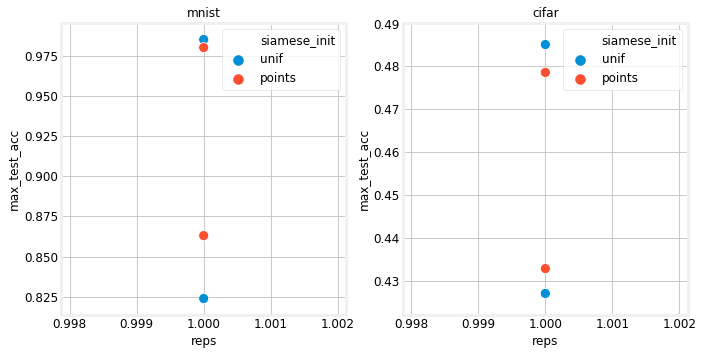

In [188]:
r = results
x = 'reps'
hue = 'siamese_init'

plt.figure(figsize=(10, 5))
R, C = 1, 2
rm = r[r.dset == 'mnist']
plt.subplot(R, C, 1)
plt.title('mnist')
sns.scatterplot(rm[x], rm.max_test_acc, hue=rm[hue])

plt.subplot(R, C, 2)
rm = r[r.dset == 'cifar10']
plt.title('cifar')
sns.scatterplot(rm[x], rm.max_test_acc, hue=rm[hue])

plt.show()

# track things over time

In [189]:
from random import randint
cs = []

for i in range(25):
    cs.append('#%06X' % randint(0, 0xFFFFFF))
cs = sorted(cs)
cs = {False: 'red', True: 'blue'}

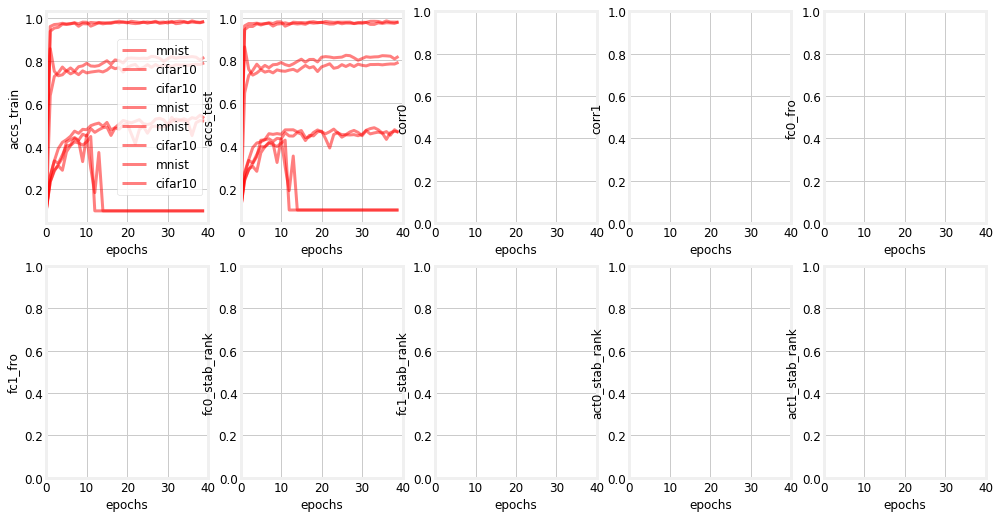

In [191]:
rm = results
# rm = rm[rm.dset == 'mnist']
# rm = rm[rm.dset == 'cifar10']
# rm = rm[rm.reset_final_weights_freq > 0]
# rm = rm[rm.reset_final_weights_freq == 10]

R, C = 2, 5
plt.figure(figsize=(15, 8))
xlim = 40

vals = ['accs_train', 'accs_test', 'corr0', 'corr1', 'fc0_fro', 'fc1_fro', 'fc0_stab_rank', 'fc1_stab_rank', 'act0_stab_rank', 'act1_stab_rank']

# hue = 'normalize_features'
hue = 'dset'
# cs = {0: cb, 1: cr, 2: 'black', 3: 'green'}
# well-behaved
for _, row in rm.iterrows():

    for i, val in enumerate(vals):
        plt.subplot(R, C, i+1)
        try:
            plt.plot(ts, row[val], color=cs[row[hue]=='sgd'], alpha=0.5)
        except Exception as e:
#             print(e)
#             plt.plot(row.its[:row[val].size], row[val], color=cs[row[hue]], alpha=0.5, label=str(row[hue]))
            try:
                plt.plot(row[val], color=cs[row[hue]=='sgd'], alpha=0.5, label=str(row[hue])) 
            except Exception as e:
                pass
        plt.xlabel('epochs')
        plt.ylabel(val)
        plt.xlim((0, xlim))
        
        if i == 0:
            plt.legend()

# look at an individual run

In [225]:
r = results
r = r[r.dset == 'cifar10']
r = r[r.reps == 1]
r = r[r.train_prototypes == True]
r = r[r.siamese_init == 'unif']
r = r[r.similarity == 'cosine']
r = r[r.max_test_acc == max(r.max_test_acc)]


run = r.iloc[0]
exs = run.exs
print(run.dset, run.max_test_acc, exs.shape, run.siamese_init, run.similarity)

cifar10 0.4851 (10, 3072) unif cosine


In [226]:
# get processed data
epoch = max(ts)
run['num_layer'] = int(run['num_layers'])
run['hidden_size'] = int(run['hidden_size'])
run['batch_size'] = int(run.batch_size)
train_loader, test_loader = data.get_data_loaders(run)
X_train, Y_train_onehot = data.get_XY(train_loader)

Files already downloaded and verified
Files already downloaded and verified


In [227]:
# get model
run = results_w[results_w.pid == run.pid].iloc[0]
run['reps'] = int(run['reps'])
model = data.get_model(run, X_train, Y_train_onehot)
weights_dict_dict = run['weights'] # keys are epochs, vals are dicts of all weights
weights_dict = weights_dict_dict[epoch] # keys are layers, vals are weight values    
weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items()}
model.load_state_dict(weights_dict_tensors)
model = model.cuda()

*get non-processed images*

In [228]:
X_test, Y_test = data.process_loader(test_loader)

### check the model

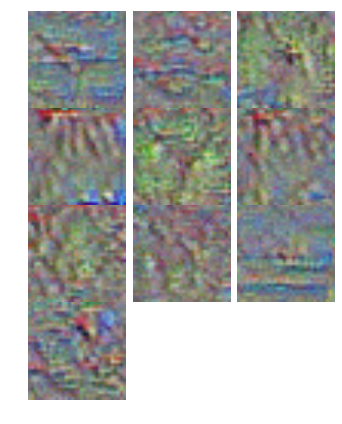

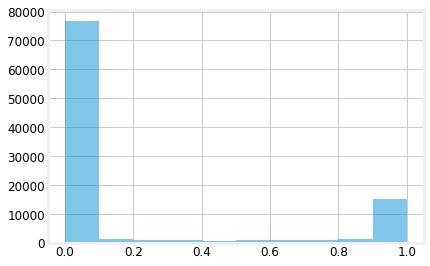

In [229]:
# exs = model.state_dict()['exs']
viz_weights.plot_weights(exs, dset=run.dset, small_fig=False, interpolation='bilinear')
preds = model.forward(X_test).cpu().detach().numpy()
plt.show()
plt.hist(preds.flatten())
plt.show()

*top/bot activating images*

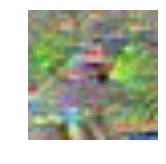

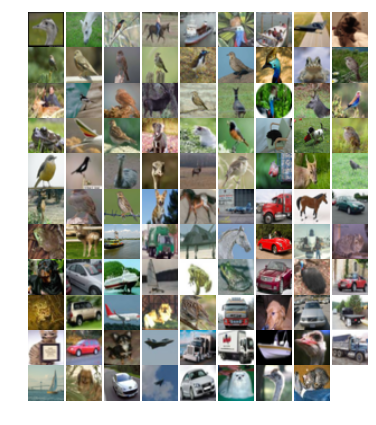

In [224]:
lab = 2 // run.reps
i0 = preds[:, lab].argsort()[::-1]
preds_sorted = preds[i0]

ims_sorted = X_test.cpu().numpy()[i0]
labs_sorted = Y_train[i0]

exs = model.exs.cpu().detach().numpy()
viz_weights.plot_weights(np.expand_dims(exs[lab], 0), dset=run.dset, small_fig=True, interpolation='bilinear')
viz_weights.plot_weights(np.concatenate((ims_sorted[:49], ims_sorted[-49:]), axis=0), dset=run.dset, interpolation='bilinear')